In [1]:
import datetime
import os
import time

import keras
import matplotlib as plt
import matplotlib.pyplot as pplt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.metrics
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from keras import backend as K
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical
from progress.bar import IncrementalBar
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.utils import to_categorical

2024-05-06 11:26:20.606217: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
rng = np.random.default_rng()

In [3]:
def plot_grid(X, ncols=2, nrows=2, figsize=(10, 10), hide_axes=True):
    fig, ax = pplt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    imgs = X[rng.choice(np.arange(X.shape[0]), size=ax.shape)].reshape(*ax.shape, 28, 28)
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap='gray')
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [4]:
def plot_grid_and_label(X, y, model, ncols=2, nrows=2, figsize=(10, 10), hide_axes=True, flatten_image=True, label_description=None):
    fig, ax = pplt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    idx = rng.choice(np.arange(X.shape[0]), size=ax.shape)
    imgs, labels = X[idx], y[idx]
    inputs = imgs.reshape(-1, *imgs.shape[2:])
    
    if flatten_image:
        inputs = inputs.reshape(nrows * ncols, -1)
        
    map_label = (lambda x: x) if label_description is None else (lambda x: label_description[x])
        
    preds = np.argmax(tf.nn.softmax(model.predict(inputs)), axis=-1).reshape(nrows, ncols)
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap='gray')
            ax[i, j].set_title(f'label: {map_label(labels[i, j])}, prediction: {map_label(preds[i, j])}')
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [72]:
X, y = sklearn.datasets.fetch_openml('Kuzushiji-49', version=1, return_X_y=True, as_frame=False, parser='auto')
y = np.array(list(map(int, y)))
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [73]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((203184, 784), (67728, 784), (203184,), (67728,))

In [6]:
label_description = [
     'A',   'I',   'U',  'E',  'O',
    'KA',  'KI',  'KU', 'KE', 'KO',
    'SA', 'SHI',  'SU', 'SE', 'SO',
    'TA', 'CHI', 'TSU', 'TE', 'TO',
    'NA',  'NI',  'NU', 'NE', 'NO',
    'HA',  'HI',  'FU', 'HE', 'HO',
    'MA',  'MI',  'MU', 'ME', 'MO',
    'YA',         'YU',       'YO',
    'RA',  'RI',  'RU', 'RE', 'RO',
    'WA',  'II',        'EE', 'WO',
     'N',  'IT'
]

In [7]:
counts = { j: np.sum(y_train == i) for i, j in enumerate(label_description) }
counts

{'A': 5209,
 'I': 5182,
 'U': 5236,
 'E': 695,
 'O': 5286,
 'KA': 5205,
 'KI': 5290,
 'KU': 5307,
 'KE': 4053,
 'KO': 5260,
 'SA': 5285,
 'SHI': 5233,
 'SU': 5244,
 'SE': 3609,
 'SO': 3335,
 'TA': 5273,
 'CHI': 2224,
 'TSU': 5210,
 'TE': 5255,
 'TO': 5205,
 'NA': 5225,
 'NI': 5310,
 'NU': 1824,
 'NE': 2132,
 'NO': 5288,
 'HA': 5286,
 'HI': 4495,
 'FU': 5281,
 'HE': 5183,
 'HO': 1755,
 'MA': 5333,
 'MI': 2655,
 'MU': 1507,
 'ME': 2938,
 'MO': 5266,
 'YA': 5275,
 'YU': 1361,
 'YO': 5234,
 'RA': 5261,
 'RI': 5219,
 'RU': 5235,
 'RE': 5275,
 'RO': 1858,
 'WA': 2068,
 'II': 371,
 'EE': 350,
 'WO': 5249,
 'N': 5267,
 'IT': 3087}

## Resolving imbalanced classes problem

In [8]:
smt = SMOTE()
X_res, y_res = smt.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)

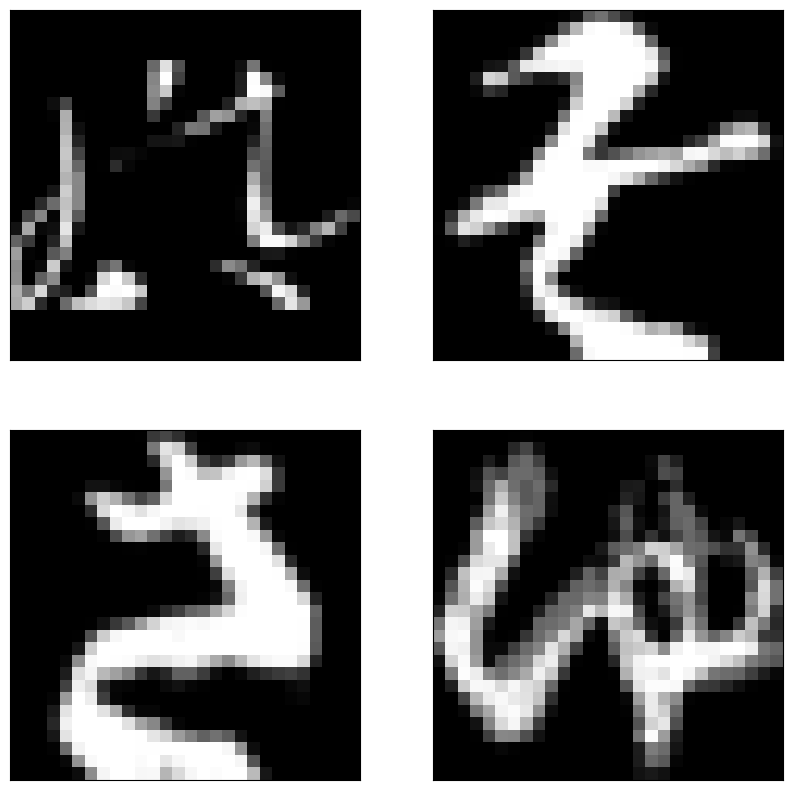

In [9]:
plot_grid(X_train)

## Flattened images

In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(49, activation=tf.nn.softmax))

In [13]:
logdir = os.path.join('logs/kuzushiji-49/', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(logdir, save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(logdir, update_freq=10)
]

In [14]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
model.fit(X_train, y_train, 
          epochs=5, 
          callbacks=callbacks, 
          validation_data=(X_test, y_test))

Epoch 1/5
8025/8040 [============================>.] - ETA: 0s - loss: 1.0374 - accuracy: 0.7292

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


8040/8040 [==============================] - 18s 2ms/step - loss: 1.0366 - accuracy: 0.7293 - val_loss: 0.6726 - val_accuracy: 0.8181
Epoch 2/5
8032/8040 [============================>.] - ETA: 0s - loss: 0.5415 - accuracy: 0.8529

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


8040/8040 [==============================] - 17s 2ms/step - loss: 0.5415 - accuracy: 0.8529 - val_loss: 0.5079 - val_accuracy: 0.8610
Epoch 3/5
8033/8040 [============================>.] - ETA: 0s - loss: 0.4266 - accuracy: 0.8819

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


8040/8040 [==============================] - 17s 2ms/step - loss: 0.4268 - accuracy: 0.8819 - val_loss: 0.4414 - val_accuracy: 0.8799
Epoch 4/5
8027/8040 [============================>.] - ETA: 0s - loss: 0.3656 - accuracy: 0.8986

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


8040/8040 [==============================] - 17s 2ms/step - loss: 0.3656 - accuracy: 0.8986 - val_loss: 0.4130 - val_accuracy: 0.8880
Epoch 5/5
8035/8040 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.9089

INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


INFO:tensorflow:Assets written to: logs/kuzushiji-49/20240506-112739/assets


8040/8040 [==============================] - 17s 2ms/step - loss: 0.3257 - accuracy: 0.9089 - val_loss: 0.3942 - val_accuracy: 0.8931


In [16]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss, val_acc)

2680/2680 [==============================] - 2s 686us/step - loss: 0.3942 - accuracy: 0.8931
0.39422711730003357 0.8931311964988708


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 49)                6321      
                                                                 
Total params: 123,313
Trainable params: 123,313
Non-trainable params: 0
_________________________________________________________________


In [18]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
images = X_test.reshape(-1, 28, 28, 1) # normalize if needed

1/1 [==============================] - 0s 19ms/step


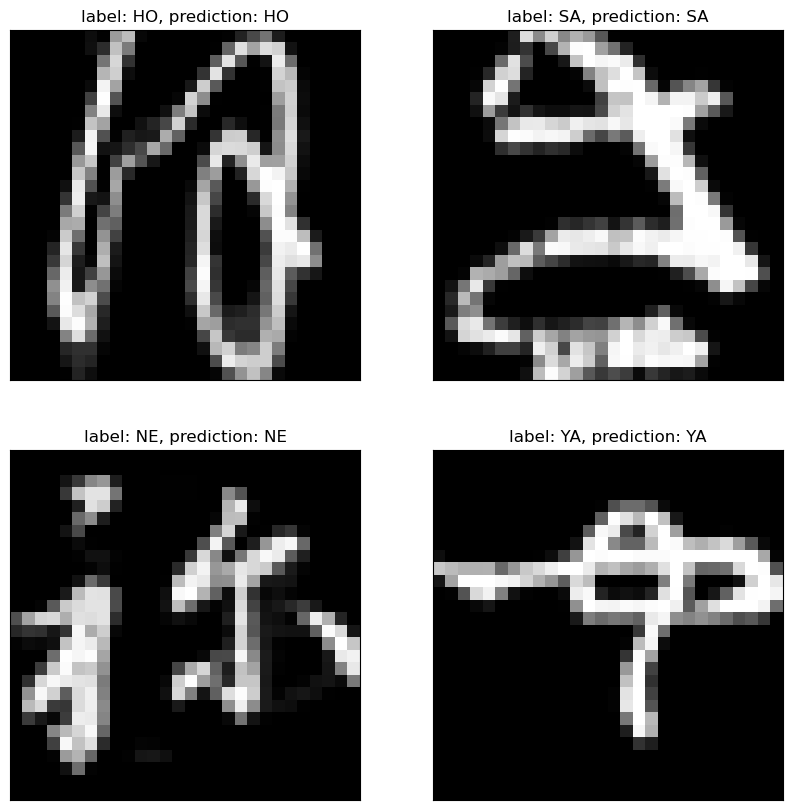

In [24]:
plot_grid_and_label(images, y_test, model, label_description=label_description)

In [29]:
y_pred = model.predict(X_test).argmax(axis=1)

2680/2680 [==============================] - 2s 668us/step


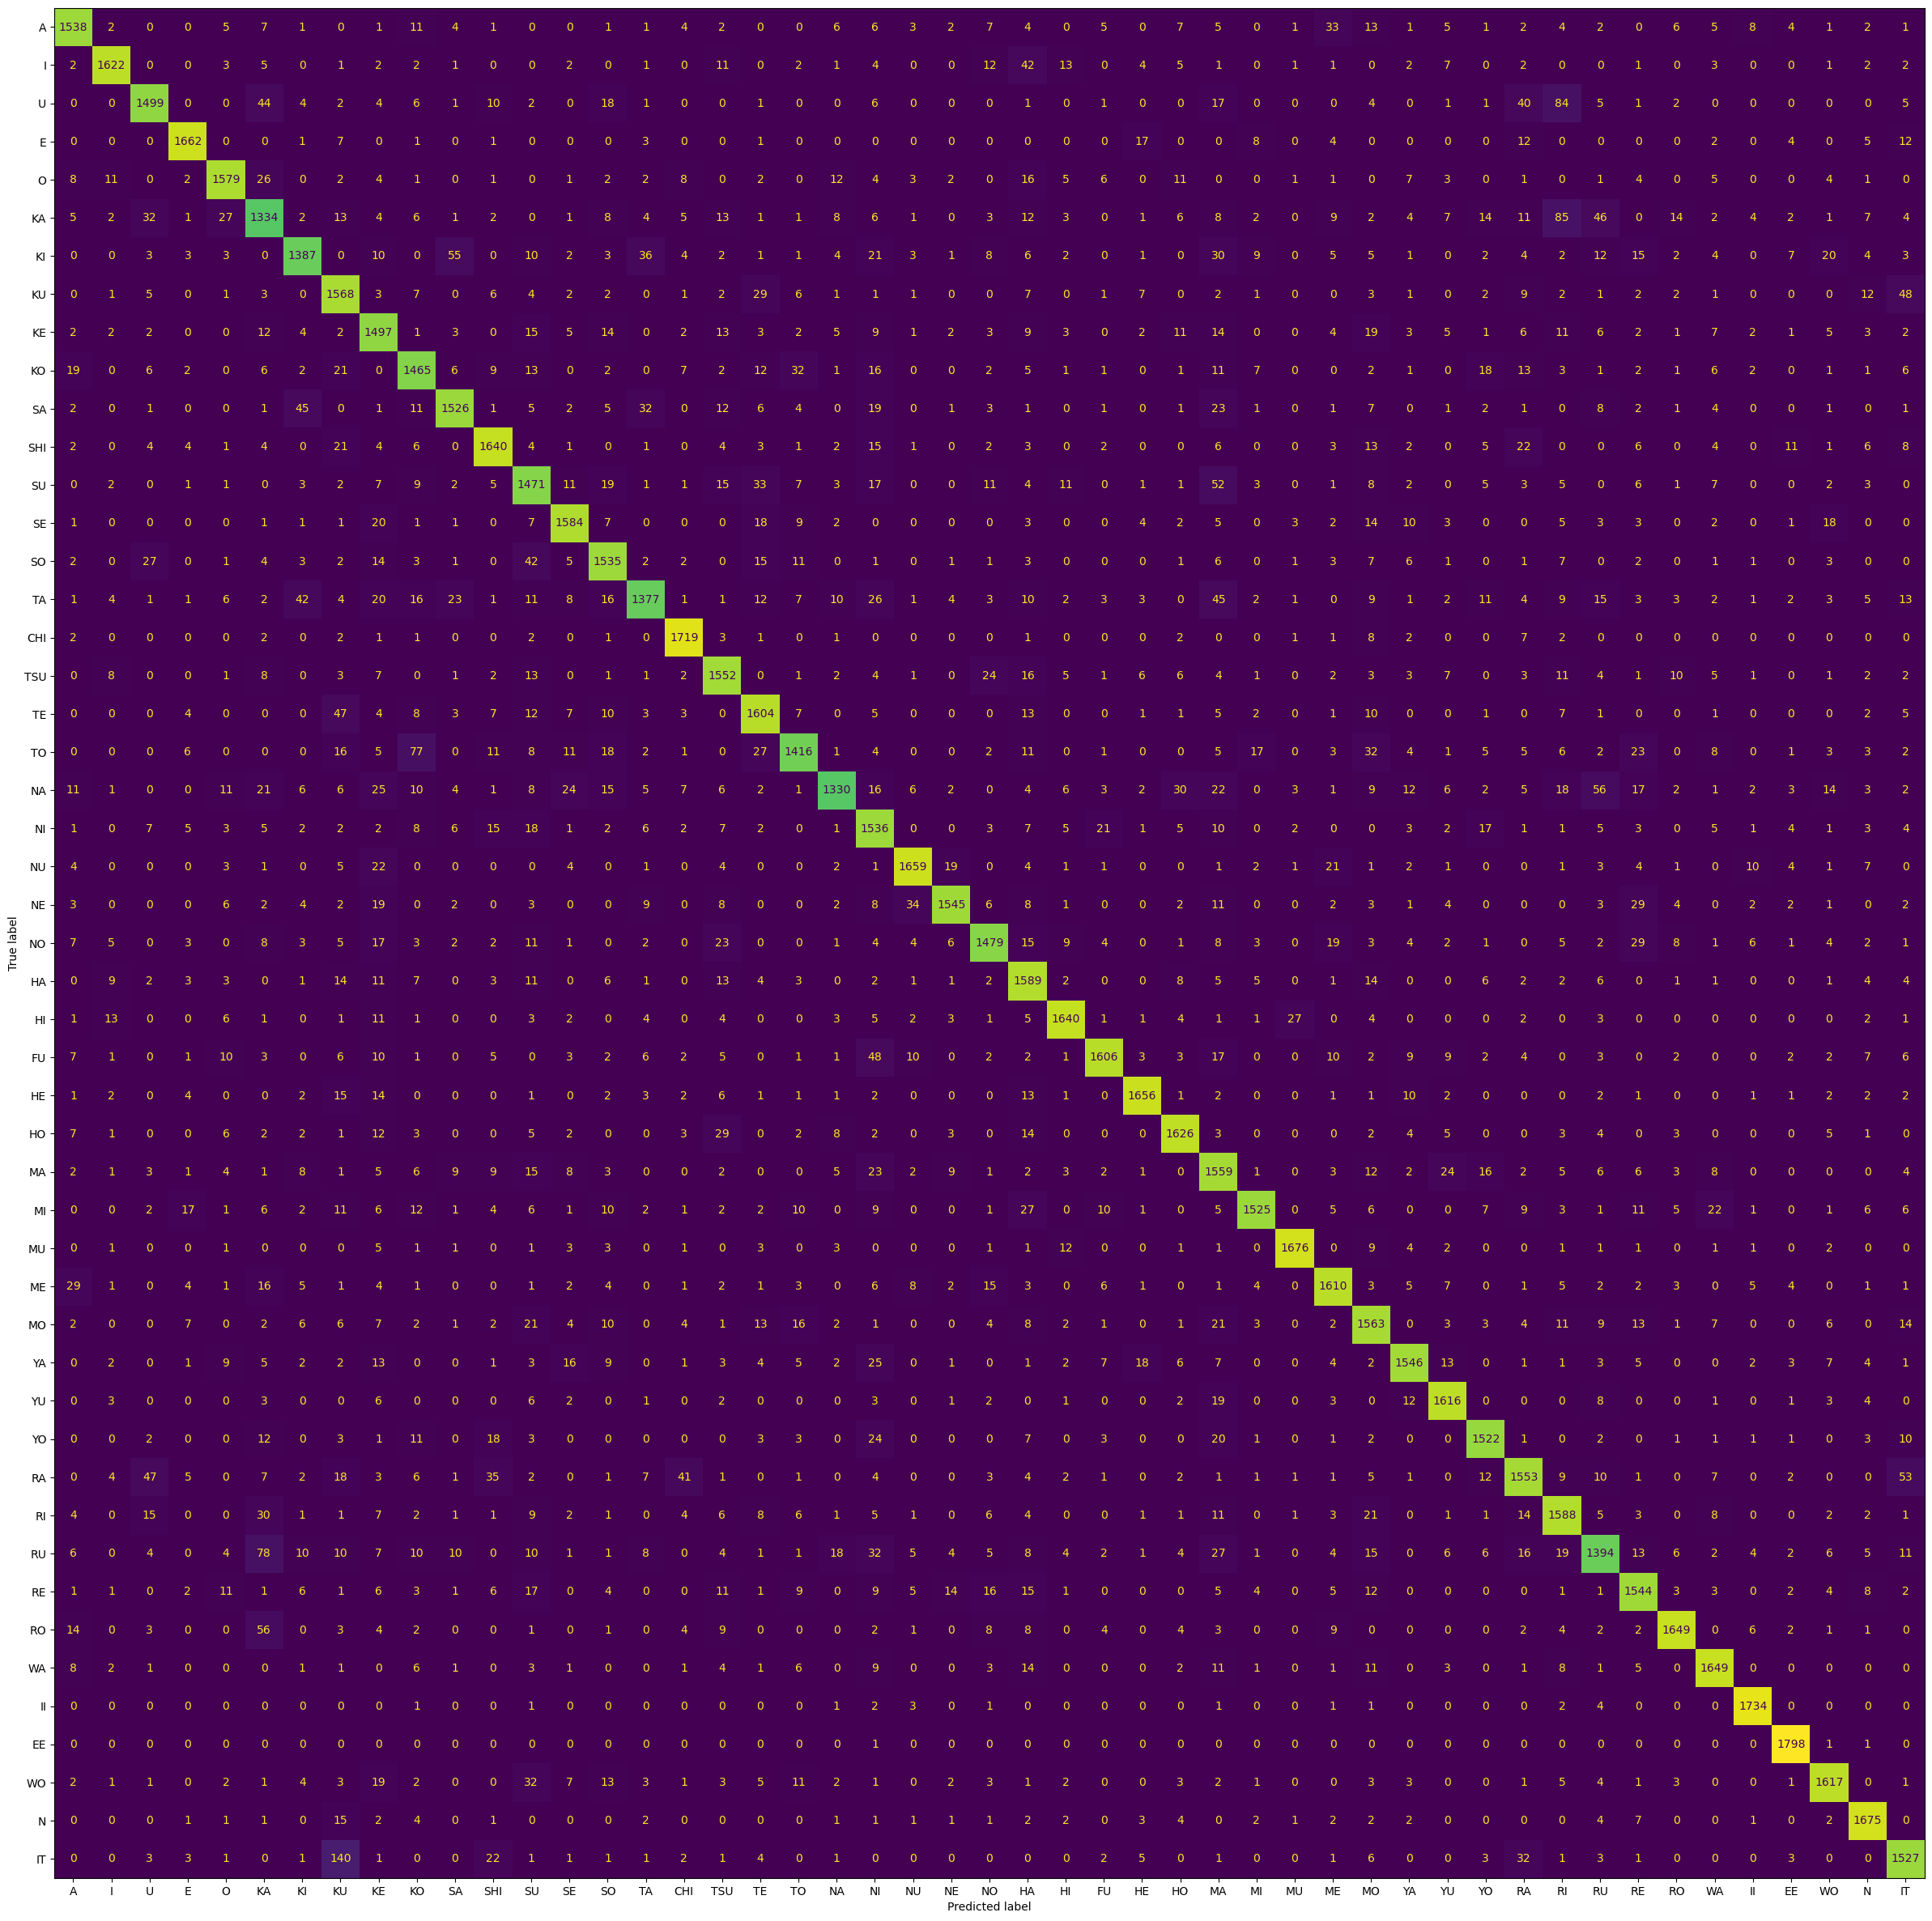

In [30]:
_, ax = pplt.subplots(figsize=(30, 30))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [31]:
accuracy = y_test == y_pred
np.mean([np.mean(accuracy[y_test == i]) for i in range(49)])

0.8930747448583877

## Actual images

In [46]:
keras.backend.clear_session()

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [85]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(28, 28, 1)))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(49, activation=tf.nn.softmax))

In [86]:
logdir = os.path.join('logs/kuzushiji-49/', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(logdir, save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(logdir, update_freq=10)
]

In [89]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [90]:
model.fit(X_train, y_train, 
          epochs=5, 
          callbacks=callbacks, 
          validation_data=(X_test, y_test))

Epoch 1/5


2024-05-06 11:56:56.039395: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: logits and labels must have the same first dimension, got logits shape [25088,49] and labels shape [32]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/63/nnp93mnj0sdd_9ffthxmct280000gn/T/ipykernel_1561/3912728520.py", line 1, in <module>
      model.fit(X_train, y_train,
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/Users/yonsan/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [25088,49] and labels shape [32]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_956588]

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
images = X_test.reshape(-1, 28, 28, 1) # normalize if needed

In [ ]:
plot_grid_and_label(images, y_test, model, label_description=label_description, flatten_image=False)

In [ ]:
y_pred = model.predict(X_test).argmax(axis=1)


In [ ]:
_, ax = plt.subplots(figsize=(30, 30))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [ ]:
accuracy = y_test == y_pred
np.mean([np.mean(accuracy[y_test == i]) for i in range(49)])